### 一.基本思路：保持局部线性关系
上一节介绍了Isomap，它的目的是维持流形中各个点之间距离一致性，我们将每个数据看做空间中的一个点，每个点与其近邻点间的距离为其欧氏距离，而其他非近邻点的点距离为无穷大，为了求解该点与非近邻点之间的距离，我们使用floyd算法求解它们之间的最短距离作为替代，而floyd算法的使用使得算法复杂度提升很多。而局部线性嵌入(Locally Linear Embedding，LLE)仅考虑了近邻点之间的线性关系，而不考虑某点与其非近邻点之间的关系，这极大的降低了算法复杂度，便于对海量数据的降维，下面介绍其基本思路
![avatar](./source/19_lle1.png)
根据上图进行介绍，大致分为三个部分：   

（1）确定$k$：确定近邻点数量$k$（类似于knn/kmeans中k的选择），这里我们选择$k=3$；  
（2）计算系数矩阵$W$：对于高维空间中的一点$x_i$，我们知道它的最近邻的三个点为$x_j,x_k,x_l$，这一步便是寻找三个系数$w_{ij},w_{ik},w_{il}$使得如下等式成立或者近似：   

$$
x_i=w_{ij}x_j+w_{ik}x_k+w_{il}x_l
$$  
(3)寻找$x_i,x_j,x_k,x_l$在低维空间中的点$z_i,z_j,z_k,z_l$，使其也满足上面的关系：   

$$
z_i=w_{ij}z_j+w_{ik}z_k+w_{il}z_l
$$  

假设高维空间样本集为$X\in R^{m\times n}$，系数矩阵为$W\in R^{m\times m}$，对应的低维空间样本集为$Z\in R^{m\times d}$，根据上面的介绍，计算流程如下：   

$$
X\rightarrow W\rightarrow Z
$$  
我们接下来对其进行推导

#### $X\rightarrow W$

我们假设每个样本点$x_i$对应的近邻下标集合为$Q_i$，那么对于$W$的求解，等价于如下的优化问题   

$$
\min_{w_1,w_2,...,w_m}\sum_{i=1}^m\left|\left|x_i-\sum_{j\in Q_i}w_{ij}x_j\right|\right|_2^2\\
s.t.\left\{\begin{matrix}
j\in Q_i & w_{ij}\geq0\\ 
j\notin Q_i & w_{ij}=0
\end{matrix}\right.\\
\sum_{j=1}^mw_{ij}=1
$$  

这是一个带约束的凸优化问题，我们可以通过KKT条件进行求解，令$C_{jk}^i=(x_i-x_j)^T(x_i-x_k)$，那么：   

$$
    w_{ij}=\frac{\sum_{k\in Q_i}\frac{1}{C_{jk}^i}}{\sum_{l\in Q_i}\sum_{s\in Q_i}\frac{1}{C_{ls}^i}}
$$  

#### $W\rightarrow Z$
对于低维空间样本点的求解，可以转换为类似的优化问题（并希望各样本之间正交）

$$
\min_{z_1,z_2,...,z_m}\sum_{i=1}^m\left|\left|z_i-\sum_{j\in Q_i}w_{ij}z_j\right|\right|_2^2\\
s.t.\left\{\begin{matrix}
z_i^Tz_j=1 & i=j\\ 
z_i^Tz_j=0 & i\neq j
\end{matrix}\right.\\
$$   

我们令$M=(I-W)^T(I-W)$，上式可以简化为   

$$
\min_Z tr(ZMZ^T)\\
s.t. ZZ^T=I
$$  

所以，我们只需要对$M$做特征分解，并去最小的$d$个特征值对应的特征向量组成的矩阵，即是$Z$

### 二.代码实现

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [2]:
#伪数据
n = 200
r = np.linspace(0,1,n)
l = np.linspace(0,1,n)

t = (3 * np.pi) / 2 * ( 1 + 2 * r )
x =  t * np.cos(t)
y = 10 * l
z =t * np.sin(t)
data=np.c_[x,y,z]

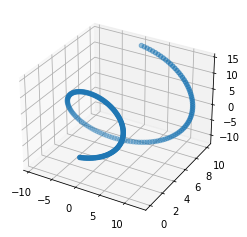

In [3]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(data[:,0],data[:,1],data[:,2], cmap='Blues')
plt.show()

In [4]:
data.shape

(200, 3)

In [5]:
#构建距离矩阵
m=data.shape[0]
D=np.zeros(shape=(m,m))
for i in range(0,m):
    for j in range(i,m):
        D[i,j]=np.sqrt(np.sum(np.power(data[i]-data[j],2)))
        D[j,i]=D[i,j]

In [6]:
#保留最近的k个坐标
k=3
idx=[]
for i in range(0,n):
    idx.append(np.argsort(D[i])[1:k+1].tolist())#最近的肯定是自身，所以下标从1开始

In [7]:
#构建权重矩阵W
C=np.zeros(shape=(n,k,k))#辅助计算W
W=np.zeros(shape=(n,n))
for i in range(0,n):
    nn_idx=idx[i]#Q_i
    for cj1 in range(0,k):
        for cj2 in range(cj1,k):
            j1=nn_idx[cj1]
            j2=nn_idx[cj2]
            c=np.dot(data[i]-data[j1],data[i]-data[j2])
            # c=1.0/c
            C[i,cj1,cj2]=c
            C[i,cj2,cj1]=c

In [8]:
for i in range(n):
    C[i] = np.linalg.inv(C[i])
C=np.sum(C,axis=2)

In [9]:
C=C/np.sum(C,axis=1,keepdims=True)

In [10]:
for i in range(0,n):
    nn_idx=idx[i]
    for cj in range(0,k):
        W[i,nn_idx[cj]]=C[i,cj]

In [11]:
#对M特征分解
M=(np.eye(n)-W).T.dot(np.eye(n)-W)
eig_vals,eig_vecs=np.linalg.eig(M)

In [12]:
sorted_indice=np.argsort(eig_vals.real)
eig_vals=eig_vals[sorted_indice]
eig_vecs[:]=eig_vecs[:,sorted_indice]

In [13]:
#保留前2维
n_compnent=2
new_data=eig_vecs.real[:,:n_compnent]

(-0.1, 0.2)

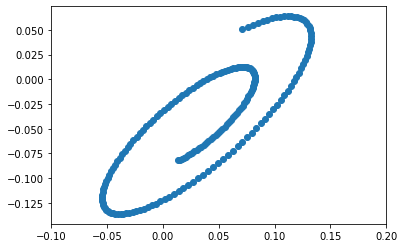

In [14]:
plt.scatter(new_data[:,0],new_data[:,1])
plt.xlim([-0.1,0.2])

代码封装到`ml_models.decomposition.LLE`中